# Algorithm Chains and Pipelines

多くの機械学習アルゴリズムでは、第4章(Prepresending Data and Engineering Features)で説明したように、提供するデータの特定の表現が非常に重要です。  
これは、データのスケーリングと機能の手動での組み合わせから始まり、第3章(Unsupervised Learning and Preprocessing)で説明したように、教師なし機械学習を使用して機能を学習するまで続きます。  
その結果、ほとんどの機械学習アプリケーションでは、単一のアルゴリズムを適用するだけでなく、多くの異なる処理ステップと機械学習モデルを連鎖させる必要があります。  
この章では、Pipelineクラスを使用して、変換とモデルのチェーンを構築するプロセスを簡素化する方法について説明します。  
特に、PipelineとGridSearchCVを組み合わせて、すべての処理ステップのパラメーターを一度に検索する方法を説明します。  

モデルの連鎖の重要性の例として、前処理にMinMaxScalerを使用することで、がんデータセットでのカーネルSVMのパフォーマンスを大幅に改善できることに気付きました。  
データの分割、最小値と最大値の計算、データのスケーリング、SVMのトレーニングのコードは次のとおりです。  

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# データをオードして分割する
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# トレーニングデータの最小値と最大値を計算します
scaler = MinMaxScaler().fit(X_train)

In [4]:
# トレーニングデータを再スケーリングします
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# スケーリングされたトレーニングデータでSVMを学習する
svm.fit(X_train_scaled, y_train)
# テストデータをスケーリングし、スケーリングされたデータをスコアリングします
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(
    svm.score(X_test_scaled, y_test)))

Test score: 0.97


## Parameter Selection with Preprocessing(前処理によるパラメータ選択)

ここで、第5章(Model Evaluation and Improvement)で説明したように、GridSearchCVを使用してSVCのより適切なパラメータを見つけたいとしましょう。  
これを行うにはどうすればよいですか。  
素朴なアプローチは次のようになります。

In [7]:
from sklearn.model_selection import GridSearchCV
# 説明のみを目的として、このコードを使用しないでください。
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(
    grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Trst set accuracy: {:.2f}".format(
    grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Trst set accuracy: 0.97


ここでは、スケーリングされたデータを使用して、SVCのパラメーターに対してグリッド検索を実行しました。  
ただし、今行ったことには微妙な問題があります。  
データをスケーリングするとき、トレーニングセット内のすべてのデータを使用して、データの最小値と最大値を計算しました。  
次に、スケーリングされたトレーニングデータを使用して、交差検定を使用してグリッド検索を実行します。  
交差検定の分割ごとに、元のトレーニングセットの一部が分割のトレーニング部分として宣言され、一部が分割のテスト部分として宣言されます。  
テストパーツは、新しいデータに適用されたときにトレーニングパーツでトレーニングされたモデルのパフォーマンスを測定するために使用されます。  
ただし、データをスケーリングするときは、分割のテスト部分に含まれる情報をすでに使用しました。  
交差検定の各分割のテスト部分はトレーニングセットの一部であり、トレーニングセット全体からの情報を使用して、データの適切なスケーリングを見つけたことを忘れないでください。  
これは、新しいデータがモデルにどのように見えるかとは根本的に異なります。  
新しいデータ（たとえば、テストセットの形式）を観察した場合、このデータはトレーニングデータのスケーリングに使用されておらず、トレーニングデータとは最小値と最大値が異なる可能性があります。  
次の例（図6-1）は、相互検証中のデータ処理と最終評価の違いを示しています。

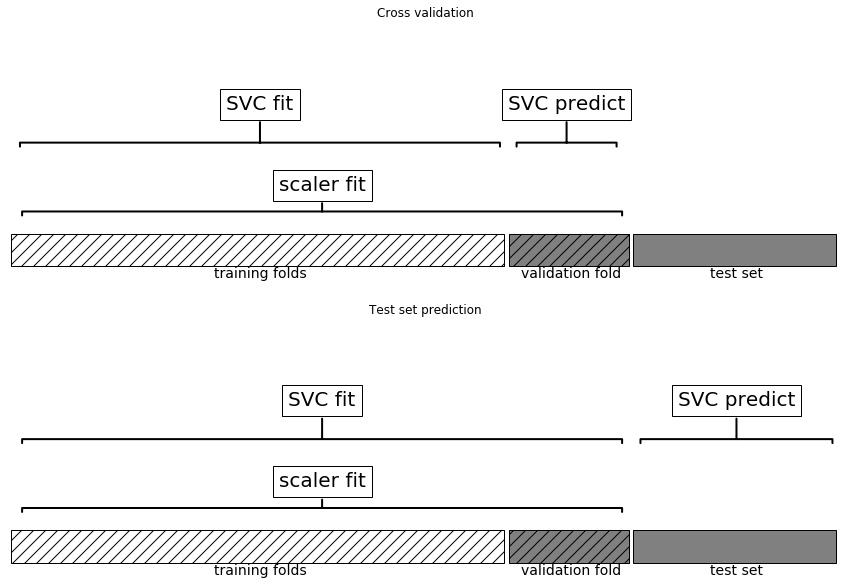

In [16]:
import mglearn
mglearn.plots.plot_improper_processing()

**Figure 6-1. Data usage when preprocessing outside the cross-validation loop**

そのため、相互検証の分割は、新しいデータがモデリングプロセスにどのように見えるかを正しく反映しなくなりました。  
データのこれらの部分からモデリングプロセスに情報を漏らしました。  
これにより、交差検定中に過度に楽観的な結果が得られ、場合によっては次善のパラメーターが選択されます。  

この問題を回避するには、前処理を行う前に、相互検証中のデータセットの分割を行う必要があります。  
データセットから知識を抽出するプロセスは、データセットのトレーニング部分からのみ学習する必要があるため、相互検証ループ内に含める必要があります。

cross_val_score関数とGridSearchCV関数を使用してscikit-learnでこれを実現するには、Pipelineクラスを使用できます。  
Pipelineクラスは、複数の処理ステップを1つのscikit-learn推定量(estimator)に「gluing(接着)」できるようにするクラスです。  
Pipelineクラス自体には、fit、predict、scoreメソッドがあり、scikit-learnの他のモデルと同じように動作します。  
Pipelineクラスの最も一般的な使用例は、前処理ステップ（データのスケーリングなど）を分類器などの教師ありモデルと連鎖させることです。

## Building Pipelines

MinMaxScalerでデータをスケーリングした後（今のところグリッド検索なし）、SVMをトレーニングするためのワークフローを表現するためにPipelineクラスを使用する方法を見てみましょう。  
まず、stepsのlistを提供することにより、パイプラインオブジェクトを構築します。  
各ステップ(steps)は、名前（選択した任意の文字列$^1$）と推定量のインスタンスを含むタプルです。  

> 1: 1つの例外を除いて、名前に二重下線__を含めることはできません。

In [17]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

ここでは、2つのステップを作成しました。  
1つ目は「scaler」と呼ばれ、MinMaxScalerのインスタンスであり、2つ目は「svm」と呼ばれ、SVCのインスタンスです。  
これで、他のscikit-learn推定器と同様に、パイプラインを適合させることができます。

In [18]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

ここで、pipe.fitは、最初に最初のステップ（スケーラー）でfitを呼び出し、次にスケーラーを使用してトレーニングデータを変換し、最後にSVMをスケーリングされたデータに適合させます。  
テストデータを評価するには、pipe.scoreを呼び出すだけです。

In [19]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.97


## Using Pipelines in Grid Searches(グリッド検索でのパイプラインの使用)

グリッド検索でpipelineを使用することは、他の推定量を使用する場合と同じように機能します。  
検索するパラメーターグリッドを定義し、パイプラインとパラメーターグリッドからGridSearchCVを構築します。  
ただし、パラメータグリッドを指定する場合、わずかな変更があります。  
パラメータごとに、パイプラインのどのステップに属するかを指定する必要があります。  
調整したい両方のパラメーター、Cとgammaは、2番目のステップであるSVCのパラメーターです。  
このステップに「svm」という名前を付けました。  
パイプラインのパラメーターグリッドを定義する構文は、各パラメーターにステップ名、__（二重アンダースコア）、パラメーター名の順に指定することです。  
したがって、SVCのCパラメータを検索するには、パラメータグリッドディクショナリのキーとして「svm__C」を使用する必要があります。  
同様に、ガンマについても同様です。

In [22]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
             'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

このパラメータグリッドを使用すると、通常どおりGridSearchCVを使用できます。

In [24]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(
    grid.best_score_))
print("Test set score: {:.2f}".format(
    grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


以前に行ったグリッド検索とは対照的に、交差検定の各分割について、MinMaxScalerはトレーニング分割のみで再適合され、テスト分割からパラメーター検索に情報がリークされることはありません。  
これ（図6-2）をこの章の前半の図6-1と比較してください。

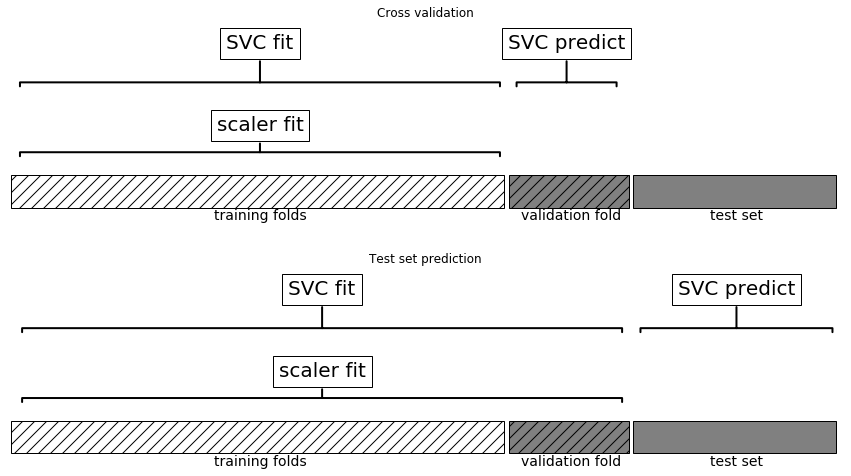

In [26]:
mglearn.plots.plot_proper_processing()

**Figure 6-2. Data usage when preprocessing inside the cross-validation loop with a pipeline**

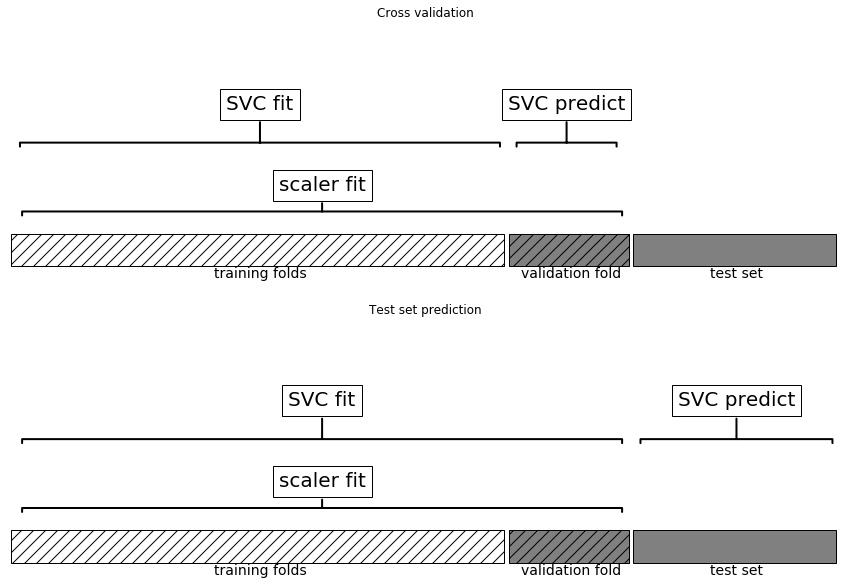

In [29]:
# figure 6-1
mglearn.plots.plot_improper_processing()

相互検証で情報が漏洩した場合の影響は、前処理ステップの性質によって異なります。  
通常、テストフォールドを使用してデータのスケールを推定しても、ひどい影響はありませんが、特徴抽出と特徴選択でテストフォールドを使用すると、結果に大きな違いが生じる可能性があります。

**ILLUSTRATING INFORMATION LEAKAGE(情報漏えいの図解)**  

相互検証で情報が漏洩する良い例は、Hastie、Tibshirani、およびFriedmanの著書The Elements of Statistics Learningに記載されており、ここで適合バージョンを再現します。  
ガウス分布から独立してサンプリングされた100個のサンプルと10,000個の特徴を使用した合成回帰タスクについて考えてみましょう。  
また、ガウス分布からの応答をサンプリングします。

In [31]:
import numpy as np
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

データセットの作成方法を考えると、データXとターゲットy（これらは独立しています）の間に関係がないため、このデータセットから何も学習できないはずです。  
次に、以下を実行します。  
まず、SelectPercentile特徴選択を使用して10,000個の特徴の中で最も有益なものを選択し、次に交差検定を使用してRidge回帰を評価します。

In [32]:
from sklearn.feature_selection import SelectPercentile, f_regression
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

X_selected.shape: (100, 500)


In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
    np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


交差検定によって計算された平均$R^2$は0.91であり、非常に優れたモデルであることを示しています。  
私たちのデータは完全にランダムであるため、これは明らかに正しいことではありません。  
ここで起こったことは、私たちの特徴選択が、（偶然に）ターゲットと非常によく相関している10,000のランダムな特徴の中からいくつかの特徴を選んだということです。  
交差検定の外で特徴選択を適合させるため、トレーニングとテストフォールドの両方で相関する特徴を見つけることができます。  
テストフォールドからリークした情報は非常に有益であり、非常に非現実的な結果につながりました。  
これを、パイプラインを使用した適切な相互検証と比較してみましょう。

In [35]:
pipe = Pipeline([("select",
                  SelectPercentile(score_func=f_regression,
                                  percentile=5)),
                ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
    np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


今回は、負の$R^2$スコアを取得します。  
これは、モデルが非常に貧弱であることを示しています。  
パイプラインを使用して、特徴選択は交差検定ループ内にあります。  
つまり、機能はデータのトレーニングフォールドを使用してのみ選択でき、テストフォールドは選択できません。  
特徴選択は、トレーニングセットのターゲットと相関している特徴を見つけますが、データは完全にランダムであるため、これらの特徴はテストセットのターゲットと相関していません。  
この例では、特徴選択でのデータ漏洩の問題を修正することで、モデルが非常にうまく機能していると結論付けることと、モデルがまったく機能していないと結論付けることの違いが生じます。

## The General Pipeline Interface(一般的なパイプラインインターフェイス)

Pipelineクラスは、前処理と分類に制限されていませんが、実際には、任意の数の推定量を結合できます。  
たとえば、特徴抽出、特徴選択、スケーリング、分類を含むパイプラインを、合計4つのステップで構築できます。  
同様に、最後のステップは、分類ではなく回帰またはクラスタリングである可能性があります。

パイプライン内の推定量の唯一の要件は、最後のステップを除くすべてに変換メソッドが必要であるため、次のステップで使用できるデータの新しい表現を生成できることです。

内部的には、Pipeline.fitの呼び出し中に、パイプライン呼び出しが適合し、各ステップで順番に変換されます$^2$。  
入力は前のステップの変換メソッドの出力によって与えられます。  
パイプラインの最後のステップでは、ジャストフィットが呼び出されます。  

> 2: または単にfit_transform。

いくつかの細かい部分をブラッシングすると、これは次のように実装されます。  
pipe.stepsはタプルのリストであるため、pipeline.steps[0][1]が最初の推定量、pipeline.steps[1][1]が2番目の推定量というようになります。

In [36]:
def fit(self, X, y):
    X_trainsformed = X
    for name, estimator in self.steps[:-1]:
        # 最後のステップを除くすべてのデータを反復処理し，
        # データを適合させて変換します．
        X_transformed = estimator.fit_transformed(X_trasformed, y)
    # 最後のステップに合う
    self.steps[-1][1].fit(X_transformed, y)
    return self

Pipelineを使用して予測する場合、最後のステップを除くすべてを使用してデータを同様に変換し、最後のステップでpredictを呼び出します。

In [37]:
def ptrdict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 最後のステップ以外のすべてを反復処理してデータを変換します。
        X_transformed = step[1].transform(X_transformed)
    # 最後のステップを使用して予測する
    return self.steps[-1][1].predict(X_trainsformed)

図6-3に、2つの変圧器T1とT2、および分類器（分類器と呼ばれる）のプロセスを示します。

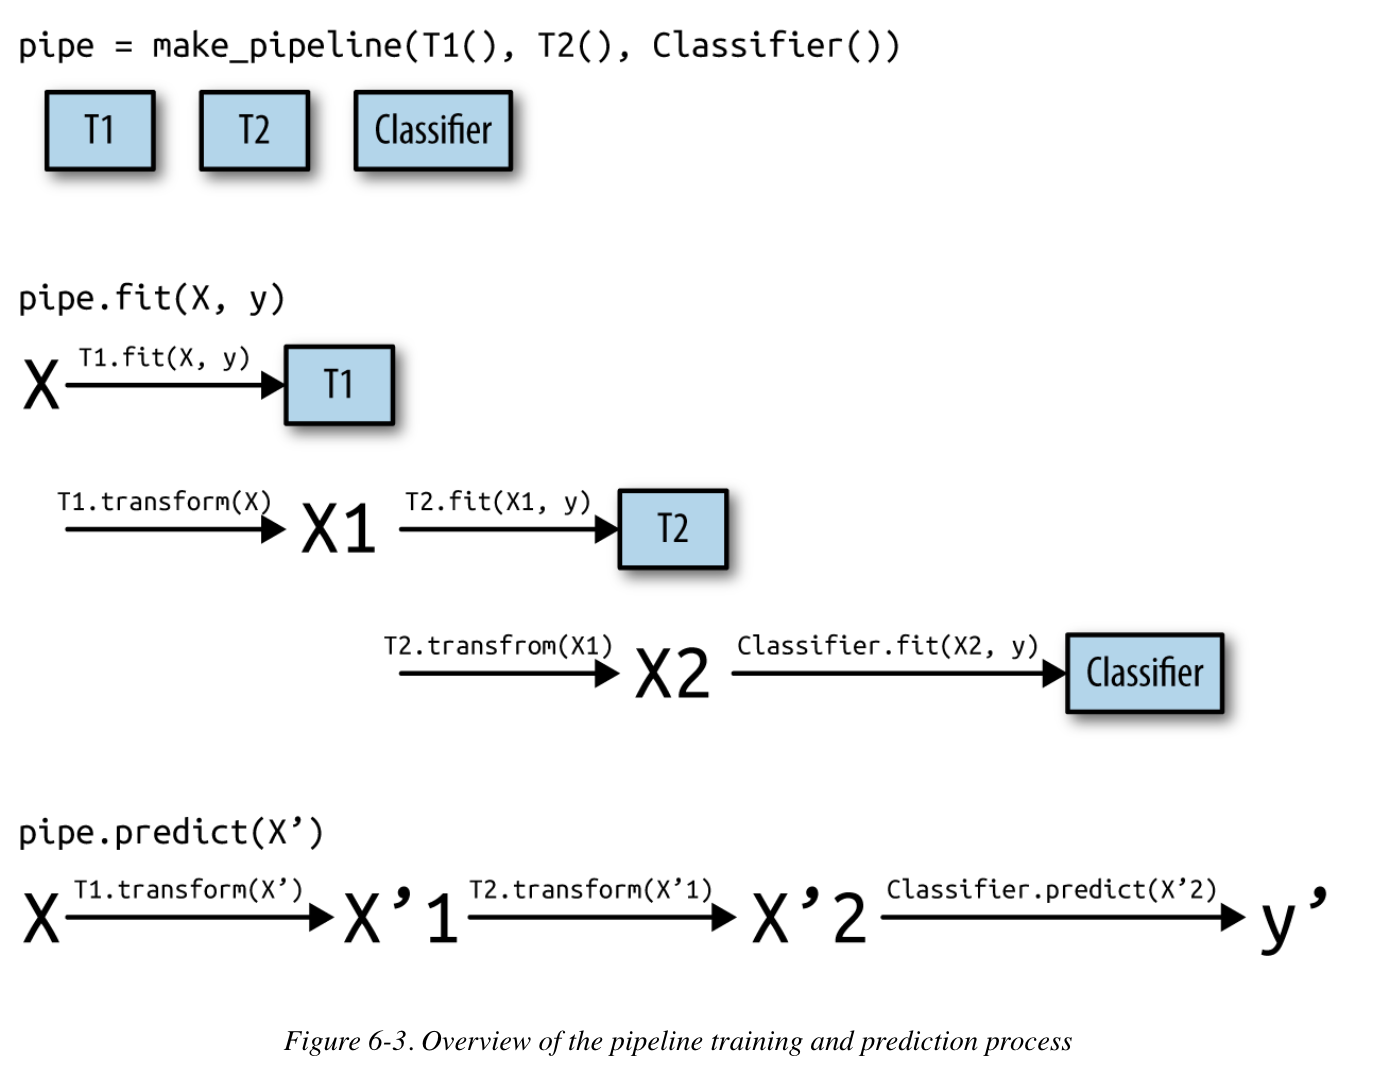

In [39]:
from IPython.display import Image
Image("images/figure_6_3.png")

パイプラインは実際にはこれよりもさらに一般的です。  
パイプラインの最後のステップに予測関数を含める必要はありません。  
たとえば、スケーラーとPCAだけを含むパイプラインを作成できます。  
次に、最後のステップ（PCA）に変換メソッドがあるため、パイプラインでtransformを呼び出して、前のステップで処理されたデータに適用されたPCA.transformの出力を取得できます。  
パイプラインの最後のステップは、fitメソッドを持つ必要があるだけです。

### Convenient Pipeline Creation with make_pipeline
**make_pipelineを使用した便利なパイプラインの作成**  

前述の構文を使用してパイプラインを作成するのは少し面倒な場合があり、各ステップにユーザー指定の名前が必要ないことがよくあります。  
便利な関数make_pipelineがあります。  
この関数は、パイプラインを作成し、クラスに基づいて各ステップに自動的に名前を付けます。  
make_pipelineの構文は次のとおりです。

In [40]:
from sklearn.pipeline import make_pipeline
# 標準構文
pipe_log = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 省略構文
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

パイプラインオブジェクトpipe_longとpipe_shortはまったく同じことを行いますが、pipe_shortには自動的に名前が付けられたステップがあります。  
ステップの属性を見ると、ステップの名前がわかります。

In [41]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]


ステップの名前はminmaxscalerおよびsvcです。  
一般に、ステップ名はクラス名の小文字バージョンです。  
複数のステップに同じクラスがある場合、番号が追加されます。

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(),
                     PCA(n_components=2),
                     StandardScaler())
print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


ご覧のとおり、最初のStandardScalerステップはstandardscaler-1、2番目のstandardscaler-2という名前でした。  
ただし、このような設定では、明示的な名前でパイプライン構造を使用して、各ステップにより多くのセマンティック名を付ける方がよい場合があります。

### Accessing Step Attributes(ステップ属性へのアクセス)

多くの場合、パイプラインのステップの1つの属性、たとえば線形モデルの係数やPCAによって抽出された成分を調べたいと思うでしょう。  
パイプラインのステップにアクセスする最も簡単な方法は、named_steps属性を使用することです。  
これは、ステップ名から推定量までの辞書です。

In [44]:
# がんデータセットに対して以前に定義されたパイプライン
pipe.fit(cancer.data)
# 「pca」ステップから最初の2つの主成分を抽出します
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


### Accessing Attributes in a Pipeline inside GridSearchCV
**GridSearchCV内のパイプラインの属性へのアクセス**  

この章の前半で説明したように、パイプラインを使用する主な理由の1つは、グリッド検索を実行するためです。  
一般的なタスクは、グリッド検索内のパイプラインのいくつかのステップにアクセスすることです。  
PipelineとStandardScalerを使用してデータをスケーリングしてからLogisticRegression分類器に渡すことにより、がんデータセットのLogisticRegression分類器をグリッド検索してみましょう。  
まず、make_pipeline関数を使用してパイプラインを作成します。

In [46]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

次に、パラメータグリッドを作成します。  
第2章で説明したように、LogisticRegressionを調整するための正則化パラメーターはパラメーターCです。  
このパラメーターには、0.01から100の間で検索する対数グリッドを使用します。  
make_pipeline関数を使用したため、パイプラインのLogisticRegressionステップの名前は次のようになります。  
小文字のクラス名、logisticregression。  
したがって、パラメーターCを調整するには、logisticregression__Cのパラメーターグリッドを指定する必要があります。

In [49]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

いつものように、がんデータセットをトレーニングセットとテストセットに分割し、グリッド検索を適合させます

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_clas

では、GridSearchCVによって検出された最良のロジスティック回帰モデルの係数にどのようにアクセスするのでしょうか。  
第5章から、すべてのトレーニングデータでトレーニングされたGridSearchCVによって検出された最良のモデルが、grid.best_estimator_に格納されていることがわかります。

In [55]:
print("Logistic regression cefficients:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression cefficients:
[[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


これはやや長い表現かもしれませんが、モデルを理解するのに役立つことがよくあります。

## Grid-Searching Preprocessing Steps and Model Parameters
**グリッド検索の前処理ステップとモデルパラメータ**  

パイプラインを使用すると、機械学習ワークフローのすべての処理ステップを単一のscikit-learn推定器にカプセル化できます。  
これを行うもう1つの利点は、回帰や分類などの教師ありタスクの結果を使用して、前処理のパラメーターを調整できることです。  
前の章では、Ridge回帰を適用する前に、ボストンデータセットで多項式フィーチャを使用しました。  
代わりにパイプラインを使用してモデル化してみましょう。　　
パイプラインには、データのスケーリング、多項式の特徴の計算、Ridge回帰の3つのステップが含まれています。

In [58]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

どの次数の多項式を選択するか、または多項式や交互作用を選択するかどうかをどのように知ることができますか？理想的には、分類の結果に基づいて次数パラメーターを選択する必要があります。  
パイプラインを使用して、Ridgeのパラメーターalphaとともに次数パラメーターを検索できます。  
これを行うには、両方を含むparam_gridを定義し、適切なプレフィックスとしてステップ名を付けます。

In [63]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

これで、グリッド検索を再度実行できます。

In [64]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                         

第5章で行ったように、ヒートマップ（図6-4）を使用して相互検証の結果を視覚化できます。

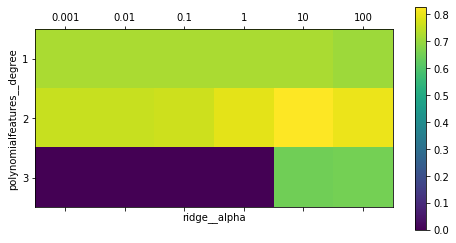

In [68]:
import matplotlib.pyplot as plt
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
           vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
          param_grid['polynomialfeatures__degree'])
plt.colorbar()

**Figure 6-4. Heat map of mean cross-validation score as a function of the degree of the polynomial features and alpha parameter of Ridge**

交差検定によって生成された結果を見ると、2次の多項式を使用すると役立つことがわかりますが、3次の多項式は1次または2次のいずれよりもはるかに悪いです。  
これは、見つかった最良のパラメーターに反映されています。

In [70]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


これは次のスコアにつながります：

In [72]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


比較のために、多項式の特徴を使用せずにグリッド検索を実行してみましょう。 

In [73]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(
    X_test, y_test)))

Score without poly features: 0.63


図6-4で視覚化されたグリッド検索結果を見ると予想されるように、多項式の特徴を使用しないと、明らかに悪い結果になります。  

モデルパラメータと一緒に前処理パラメータを検索することは、非常に強力な戦略です。  
ただし、GridSearchCVは、指定されたパラメーターの可能なすべての組み合わせを試行することに注意してください。  
したがって、グリッドにパラメーターを追加すると、構築する必要のあるモデルの数が指数関数的に増加します。

### Grid-Searching Which Model To Use(使用するモデルのGridSearching)

パイプラインで実行されている実際のステップを検索します（StandardScalerとMinMaxScalerのどちらを使用するかなど）。　　
これにより、検索スペースがさらに大きくなるため、慎重に検討する必要があります。  
考えられるすべての解決策を試すことは、通常、実行可能な機械学習戦略ではありません。  
ただし、これはアイリスデータセットのRandomForestClassifierとSVCを比較する例です。  
SVCではデータをスケーリングする必要がある可能性があることがわかっているため、StandardScalerを使用するか前処理を使用しないかについても検索します。  
RandomForestClassifierの場合、前処理は不要であることがわかっています。  
パイプラインを定義することから始めます。  
ここでは、ステップに明示的に名前を付けます。  
2つのステップが必要です。  
1つは前処理用で、次に分類器用です。  
SVCとStandardScalerを使用してこれをインスタンス化できます。

In [75]:
pipe = Pipeline([('preprocessing', StandardScaler()),
                 ('classifier', SVC())])

これで、検索するparameter_gridを定義できます。  
分類子をRandomForestClassifierまたはSVCのいずれかにする必要があります。  
調整するパラメータが異なり、前処理も異なる必要があるため、「Search over spaces that are not grids(グリッドではないスペースの検索)」で説明した検索グリッドのリストを利用できます。  
推定量をステップに割り当てるために、パラメーター名としてステップの名前を使用します。  
パイプラインのステップをスキップしたい場合（たとえば、RandomForestの前処理が必要ないため）、そのステップを[None]に設定できます。

In [77]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}
]

これで、通常どおり、がんデータセットでグリッド検索をインスタンス化して実行できます。

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


グリッド検索の結果は、StandardScaler前処理を使用したSVCであり、C = 10、ガンマ= 0.01が最良の結果をもたらしました。

### Avoiding Redundant Computation(冗長な計算の回避)

前述のような大規模なグリッド検索を実行する場合、同じ手順が数回使用されることがよくあります。  
たとえば、分類子の設定ごとに、StandardScalerが再構築されます。  
StandardScalerの場合、これは大きな問題ではないかもしれませんが、より高価な変換（PCAまたはNMFを使用した特徴抽出など）を使用している場合、これは多くの無駄な計算になります。  
この問題の最も簡単な解決策は、計算をキャッシュすることです。  
これは、joblib.Memoryオブジェクトを取得するPipelineのメモリパラメータ、またはキャッシュを格納するためのパスを使用して実行できます。  
したがって、キャッシュの有効化は次のように簡単にできます。

In [79]:
pipe = Pipeline([('preprcessing', StandardScaler()),
                 ('classifier', SVC())],
                memory="cache_folder")

この方法には2つの欠点があります。キャッシュはディスクへの書き込みによって管理されます。  
これにはシリアル化が必要であり、実際にはディスクからの読み取りと書き込みが必要です。  
これは、メモリを使用すると、比較的遅い変換のみが加速されることを意味します。  
データをスケーリングするだけで、すでにスケーリングされているデータをディスクから読み取ろうとするよりも高速になる可能性があります。  
ただし、費用のかかる変換の場合、これは依然として大きなメリットになる可能性があります。  
もう1つの欠点は、n_jobsを使用するとキャッシュが妨げられる可能性があることです。  
グリッド検索の実行順序によっては、最悪の場合、計算がキャッシュされる前に、n_jobsの量のワーカーによって同時に冗長に実行される可能性があります。  

dask-mlライブラリによって提供されるGridSearchCVの代わりを使用することで、これらの両方を回避できます。  
dask-mlを使用すると、クラスター全体に分散している場合でも、並列計算を実行しながら冗長な計算を回避できます。  
高価なパイプラインを使用していて、広範なパラメーター検索を実行している場合は、dask-mlを確認する必要があります。

## Summary and Outlook

この章では、機械学習ワークフローで複数の処理ステップを連鎖させるための汎用ツールであるPipelineクラスを紹介しました。  
機械学習の実際のアプリケーションでは、モデルを単独で使用することはめったになく、一連の処理ステップになります。  

パイプラインを使用すると、fit、predict、そしてtransformの使い慣れたscikit-learnインターフェースに準拠する単一のPythonオブジェクトに複数のステップをカプセル化できます。  

特に、cross-validation(交差検証)を使用したモデル評価とgrid search(グリッド検索)を使用したパラメーター選択を行う場合、適切な評価には、Pipelineクラスを使用してすべての処理ステップをキャプチャすることが不可欠です。  

Pipelineクラスを使用すると、より簡潔なコードを記述でき、パイプラインクラスなしで処理チェーンを構築するときに発生する可能性のある間違い（テストセットにすべてのトランスフォーマーを適用するのを忘れたり、正しい順序で適用しないなど）が発生する可能性が低くなります。  

特徴抽出、前処理、およびモデルの適切な組み合わせを選択することは、いくぶん芸術であり、多くの場合、試行錯誤が必要です。  
ただし、パイプラインを使用すると、この多くの異なる処理ステップの「trying out(試行)」は非常に簡単です。  
実験するときは、プロセスを過度に複雑にしないように注意し、モデルに含めるすべてのコンポーネントが必要かどうかを必ず評価してください。  

この章では、scikit-learnが提供する汎用ツールとアルゴリズムの調査を完了しました。  
これで、必要なスキルをすべて身に付け、機械学習を実際に適用するために必要なメカニズムを理解できました。  
次の章では、実際に一般的に見られ、正しく処理するには特別な専門知識が必要な特定の種類のデータ、つまりテキストデータについて詳しく説明します。